# IBugMask Transfer Learning

In [1]:
import segmentation_models_pytorch as smp
import label_test_script
from label_test_script import visualize, reverse_one_hot, colour_code_segmentation
import dlib
import albumentations as albu
import torch
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from segmentation_models_pytorch import utils

# HYPERPARAMS
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
SIZEX = 128
SIZEY = 128
DEVICE = torch.device("cuda")

# 11 for Helen & Lapa, 12 for Mixed & Synthetic 
num_classes = 12

# preprocessing (imagenet normalisation)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

2023-02-17 20:55:47.010760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 20:55:47.285979: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 20:55:48.337674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-17 20:55:48.337889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

## Face alignment via eye displacement angle

In [2]:
datFile = "/home/nathan/Documents/final_project/shape_predictor_5_face_landmarks.dat"
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(datFile)  

def shape_to_normal(shape):
  shape_normal = []
  for i in range(0, 5):
      shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
  return shape_normal

def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def cosine_formula(length_line1, length_line2, length_line3):
  cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
  return cos_a

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False

def align(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #face alignment
    rects = detector(gray, 0)
    if len(rects) > 0:
        for rect in rects:
            x = rect.left()
            y = rect.top()
            w = rect.right()
            h = rect.bottom()
            shape = predictor(gray, rect)
    else:
      return 0

    shape = shape_to_normal(shape)
    nose, left_eye, right_eye = get_eyes_nose_dlib(shape)
    center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    center_pred = (int((x + w) / 2), int((y + y) / 2))
    length_line1 = distance(center_of_forehead, nose)
    length_line2 = distance(center_pred, nose)
    length_line3 = distance(center_pred, center_of_forehead)
    cos_a = cosine_formula(length_line1, length_line2, length_line3)
    angle = np.arccos(cos_a)

    rotated_point = rotate_point(nose, center_of_forehead, angle)
    rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
    if is_between(nose, center_of_forehead, center_pred, rotated_point):
        angle = np.degrees(-angle)
    else:
        angle = np.degrees(angle)

    return angle

def crop_rotate(img, mask):
  """ HAAR CASCADE CLASSIFIER AND ROATER"""

  crops = []
  original = 0
  skips = []
  rejected = []
  angles = []

  # convert to gray
  gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

  face = None
  # Detect faces
  try:
    face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
    limit = int((gray.shape[0]/2))
    faces = face_cascade.detectMultiScale(gray, 1.05, 2, minSize=[limit,0])
    face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
  except:
    #print("FAILED USING FRONTAL FACE ALT 2")
    try:
      face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml")
      limit = int((gray.shape[0]/2))
      faces = face_cascade.detectMultiScale(gray, 1.05, 2, minSize=[limit,0])
      face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
    except:
      try:
        face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        limit_1 = int((gray.shape[0]/2.5))
        limit_2 = int((gray.shape[1]/1.7))
        faces = face_cascade.detectMultiScale(gray, 1.05, 3, minSize=[limit_1,0], maxSize=[50000,limit_2]) 
        face = sorted(faces,key=lambda f:f[2]*f[3])[-1]  
      except:
        #print("FAILED USING FRONTAL FACE ALT 2")
        try:
          face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
          limit_1 = int((gray.shape[0]/2.5))
          limit_2 = int((gray.shape[1]/2.5))
          faces = face_cascade.detectMultiScale(gray, minSize=[0,limit_2])
          face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
        except:
          #print("FAILED USING FRONTAL FACE ALT 2")
          try:
            face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
            limit_1 = int((gray.shape[0]/2))
            limit_2 = int((gray.shape[1]/3))
            faces = face_cascade.detectMultiScale(gray, 1.03, 1, minSize=[limit_1,0])
            face = sorted(faces,key=lambda f:f[2]*f[3])[-1]
          except:
                pass

  if face is not None:
    x, y, w, h = face
    crops.append(face)
    face = img[y:y + h, x:x + w]
    face = cv2.resize(face, (SIZEY, SIZEX))
    #cv2_imshow(face)

    angle = align(img)
    face = Image.fromarray(face)
    face_rotated = np.array(face.rotate(angle))
    angles.append(angle)

    mask = mask[y:y + h, x:x + w]
    mask = cv2.resize(mask, (SIZEY, SIZEX))
    #cv2_imshow(face)

    mask = Image.fromarray(mask)
    mask_rotated = np.array(mask.rotate(angle))

    return(face_rotated, mask_rotated, face)

  return(None, None)

[ERROR:0@0.853] global /io/opencv/modules/core/src/persistence.cpp (505) open Can't open file: 'haarcascade_frontalface_alt2.xml' in read mode


## Dataset Creation

In [3]:
rgb_vals = [0,1,2,3,4,5,6,7,8,9,10,11]

def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, mode="train", use_landmarks=True):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')]

    self.use_landmarks = use_landmarks

    if mode == "val":
      self.masks_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
      self.images_fps = [os.path.join(masks_dir, mask_id.replace("jpg","png")) for mask_id in self.image_ids]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace(".jpg", "_landmark.txt")) for coords_id in self.image_ids]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i, put_back=False):

    #print(self.masks_fps[i], self.images_fps[i])

    image = cv2.imread(self.masks_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.images_fps[i],0)

    original_image = image
    original_mask = mask

    # crop to center face
    if self.use_landmarks == True:
      smallest_x = 99999
      smallest_y = 99999
      biggest_x = -99999
      biggest_y = -99999
      with open(self.coords_fps[i], 'rb') as f:

        contents = str(f.read()).split("\\n")
        #print(contents)
        contents = [[int(float(single.replace("\\r", "").
                              replace("'", "").replace("b", "").replace("\\x1a", "")
                              )) for single in pair.split(" ")] for pair in contents[2:-2]]
        #print(contents)

        #contents = np.array(contents)
        for pair in contents:
          #plt.scatter((pair[0]), (pair[1]), color="red")

          if (pair[0]) < smallest_x:
            smallest_x = (pair[0])
          
          if (pair[0]) > biggest_x:
            biggest_x = (pair[0])

          if (pair[1]) < smallest_y:
            smallest_y = (pair[1])
          
          if (pair[1]) > biggest_y:
            biggest_y = (pair[1])

        #save original for repositioning
        crop_coords = (int(smallest_y), int(biggest_y), int(smallest_x), int(biggest_x))

        #crop to points of ineterst
        image = image[smallest_y: biggest_y, smallest_x:biggest_x]
        mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]

      try:
        mask = cv2.resize(mask, (SIZEY, SIZEY))
        image = cv2.resize(image, (SIZEY, SIZEY))
        mask = np.expand_dims(mask,2)
      except:
        return(self.__getitem__(i-1))
    
    else:
      # use haar classifier
      image, mask, crop_coords = crop_rotate(image, mask)
      mask = np.expand_dims(mask,2)
      if image is None:
        return(self.__getitem__(i-1))
        
    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), num_classes).permute(0,3,1,2).float().squeeze(0)

    if put_back == True:
      return (image, one_hot_Y, original_image, original_mask, crop_coords)

    else:
      #print(self.masks_fps[i])
      return (image, one_hot_Y)

  def get_og(self, i):
    return self.__getitem__(i, put_back=True)

val_img_path = "/home/nathan/Documents/final_project/datasets/ibugmask_release/test/test2"
#val_img_path = "/home/nathan/Documents/final_project/datasets/ibugmask_release/test/test3"
#val_img_path = "/home/nathan/Documents/final_project/datasets/ibugmask_release/train"
val_mask_path = val_img_path
val_coord_path= val_img_path

val_ds = MyDataSet(val_mask_path,
                   val_img_path,
                   val_coord_path,
                   preprocessing=get_preprocessing(preprocessing_fn),
                   augmentation=get_validation_augmentation(), 
                   mode="val",
                   use_landmarks=True)

#image_vis, gt_mask = val_ds[20]

### Sanity Check

/tmp/ipykernel_63263/1727812118.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


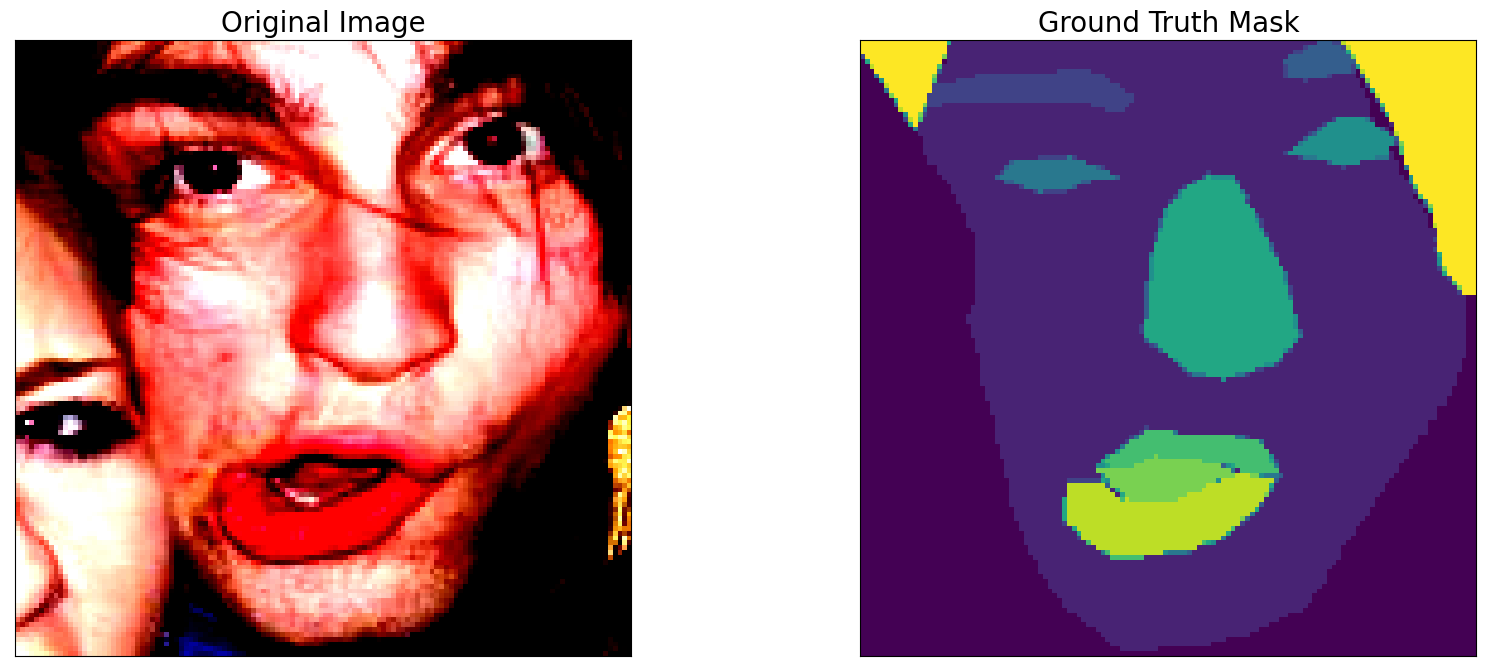

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


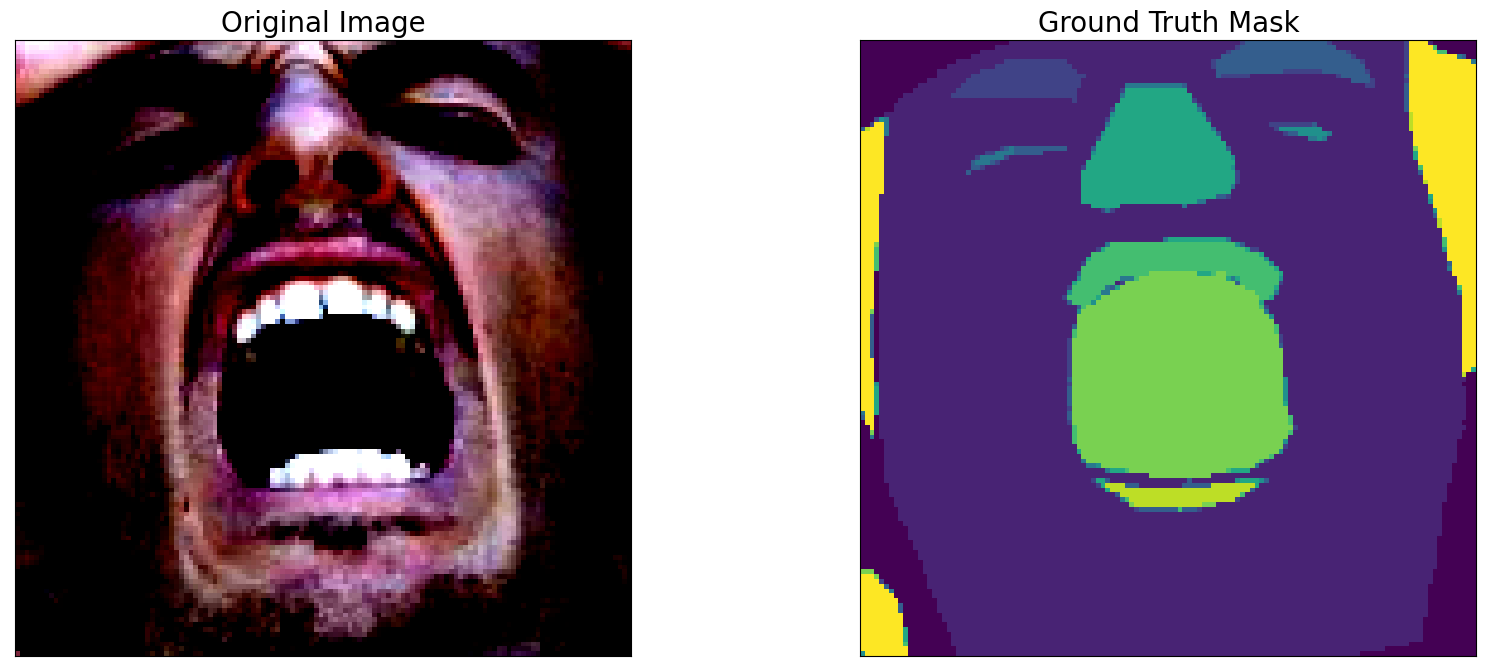

In [4]:
from matplotlib import pyplot as plt
import label_test_script
from label_test_script import colour_code_segmentation, reverse_one_hot, visualize

for x in range(2):

  image_vis, gt_mask = val_ds[x]
  #print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

  visualize(
      original_image = image_vis.transpose(1,2,0),
      ground_truth_mask = gt_mask
  )

## Train Model

### Function to view train model precitions

In [5]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes, amount=-1, visualise=False):

    ious = []
    f1s = []

    if amount == -1:
      amount = len(ds)

    #predict
    for idx in range(amount):

        image, gt_mask, og_image, og_mask, coords = ds.get_og(idx)
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        #m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        #m.update_state(gt_mask, pred_mask)
        #iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        #ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = 0.1
          #print(f1)
          f1s.append(np.array(f1))

        if visualise:
          if idx< 1:
            visualize(
                img_crop = image.transpose(1,2,0),
                gt_crop= gt_mask,
                pred_crop = pred_mask,
            )
            
            
            og_image = og_image
            upscale_coords = og_image[coords[0]: coords[1], coords[2]:coords[3]].shape
            pred_mask = Image.fromarray(pred_mask.astype(np.uint8)).resize(upscale_coords[:-1][::-1])
            pred_mask = cv2.cvtColor(np.array(pred_mask),cv2.COLOR_GRAY2RGB)
            pred_mask =Image.fromarray(pred_mask)

            [xs,ys]=pred_mask.size  #width*height
            colour_dict = {0:(0,0,0), 1:(39,65,135), 2:(70,136,154), 3:(52,158,136), 4:(37,157,97), 5:(23,180,23), 
                            6:(22,180,23), 7:(113,203,58), 8:(219,213,68), 9:(230,109,11), 10:(255,56,10), 11:(0,0,0), 12:(0,0,0)}
                            
            # Examine every pixel in im
            for x in range(0,xs):
              for y in range(0,ys):
                #get the RGB color of the pixel
                [r,g,b]=pred_mask.getpixel((x, y))
                value = colour_dict[r]
                pred_mask.putpixel((x, y), value)
            
            #print(np.array(pred_mask).shape, og_image.shape, upscale_coords)

            pred_mask = np.array(pred_mask)
            for x, rows in enumerate(pred_mask):
              for y, columns in enumerate(rows):
                r = pred_mask[x,y][0]
                if r != 0:

                  og_image[x+int(coords[0]),y+int(coords[2])] = pred_mask[x,y]
                else:
                  pass

            plt.imshow(og_image,interpolation='none')
            plt.show()
          

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    #av_f1s_av = av_f1s.mean(axis=0)

    #print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    #print ("Dataset F1 av = ", av_f1s_av)

/tmp/ipykernel_63263/3538289849.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### Function to save predicitons to disk

In [6]:
def save_predictions(model, ds):
  #predict
  for idx in range(len(ds)):

      # Pop image from DS
      image, gt_mask = ds[idx]
      image_vis = image
      image_vis = np.transpose(image_vis,(1,2,0))
      
      # Reshape
      x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(x_tensor)
      # Reshape
      pred_mask = pred_mask.detach().squeeze().cpu()
      
      # Decode Onehots
      pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
      gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

      pred_mask = Image.fromarray(np.uint8(pred_mask)).save("/home/nathan/Documents/final_project/datasets/label_adapter_helen_train/images/"+str(idx)+".png",quality='keep')
      gt_mask = Image.fromarray(np.uint8(gt_mask)).save("/home/nathan/Documents/final_project/datasets/label_adapter_helen_train/masks/"+str(idx)+".png",quality='keep')

      #gt_mask = scipy.signal.medfilt(gt_mask, 9)

      print("saving", idx, "/", len(ds), end="\r")

# Predict!

deeplab:


/tmp/ipykernel_51688/3538289849.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


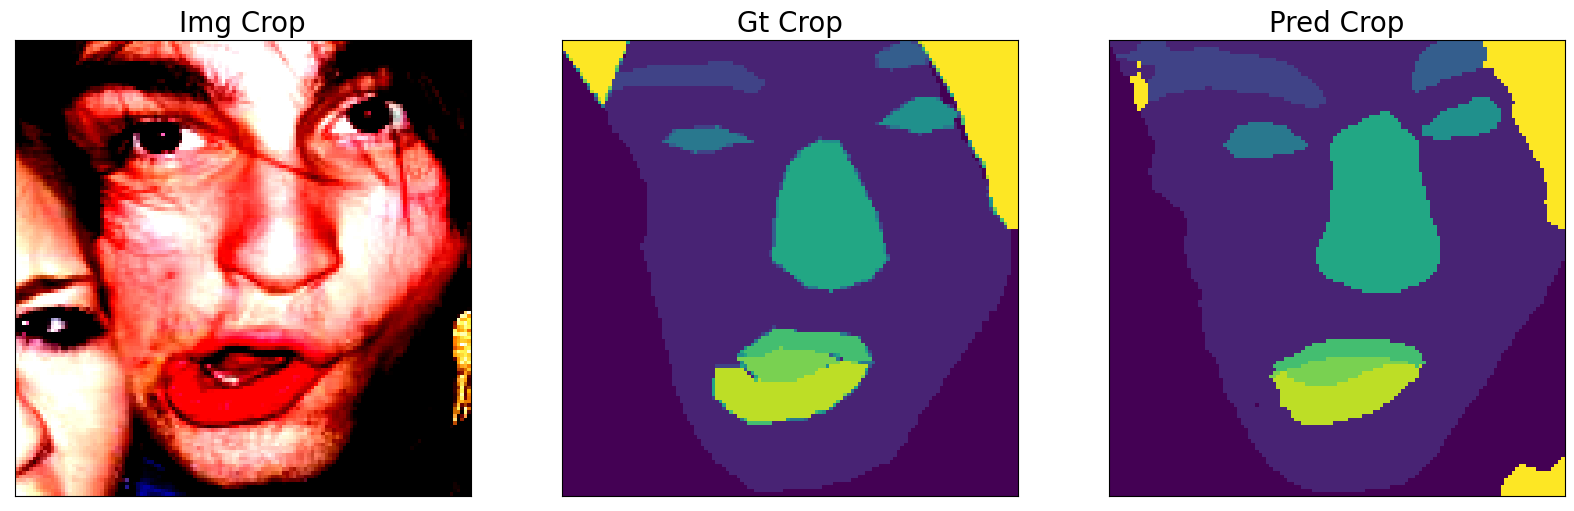

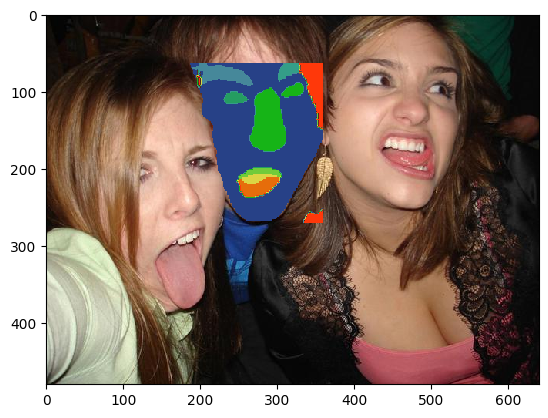

Dataset F1 =  [0.6475777  0.9001474  0.40045178 0.47863522 0.47203884 0.4597498
 0.8194934  0.5978357  0.5170236  0.6437076  0.57327855 0.09999996]
Dataset F1 =  [0.752973   0.9224216  0.64521354 0.65059656 0.6780986  0.6704664
 0.8896089  0.573473   0.66409427 0.8115945  0.6499622         nan]
Dataset F1 av =  nan
FPN:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


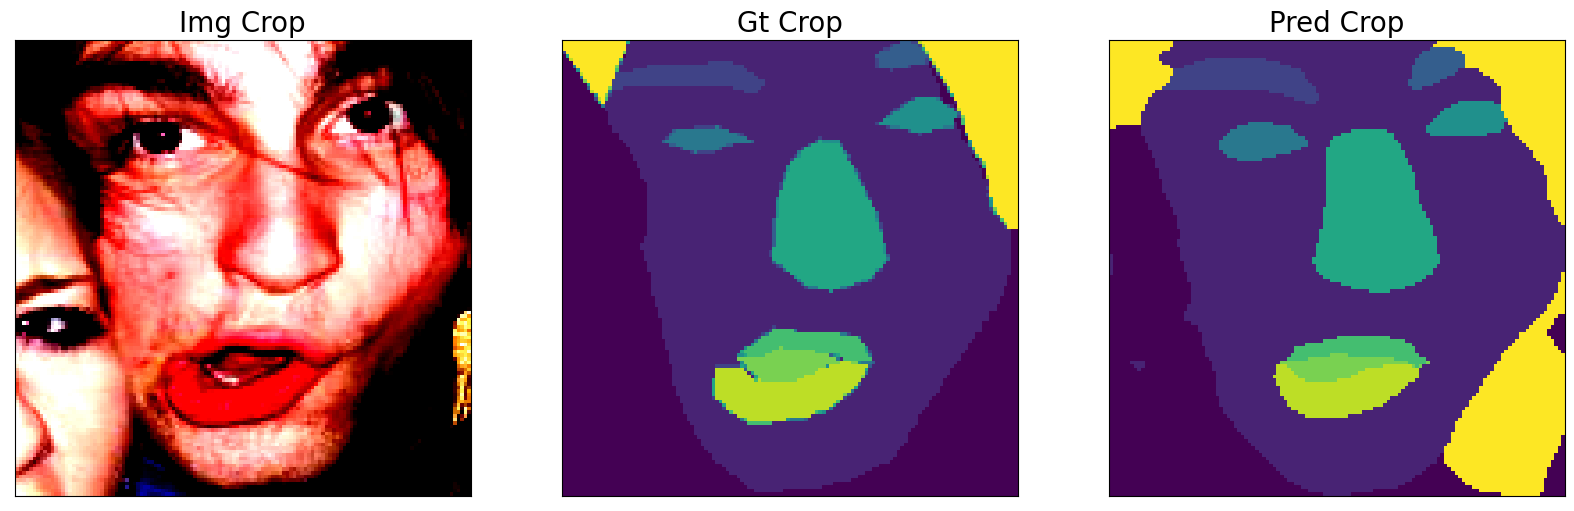

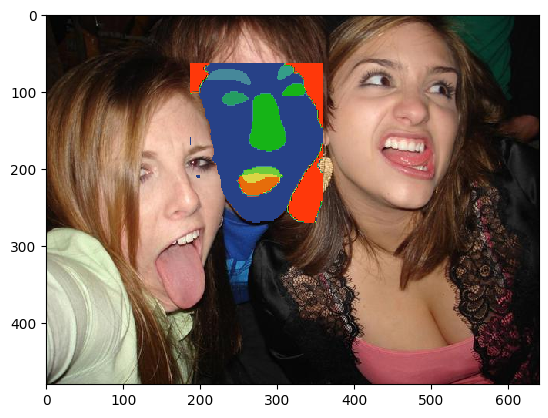

Dataset F1 =  [0.5987539  0.9001918  0.41755885 0.47760704 0.4677653  0.4504476
 0.8335881  0.5971424  0.5128676  0.657886   0.60593104 0.09999996]
Dataset F1 =  [0.7530563  0.9224525  0.6460454  0.6505826  0.67834467 0.6702443
 0.88974386 0.5733573  0.66339064 0.8121368  0.6504251         nan]
Dataset F1 av =  nan
UNET:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


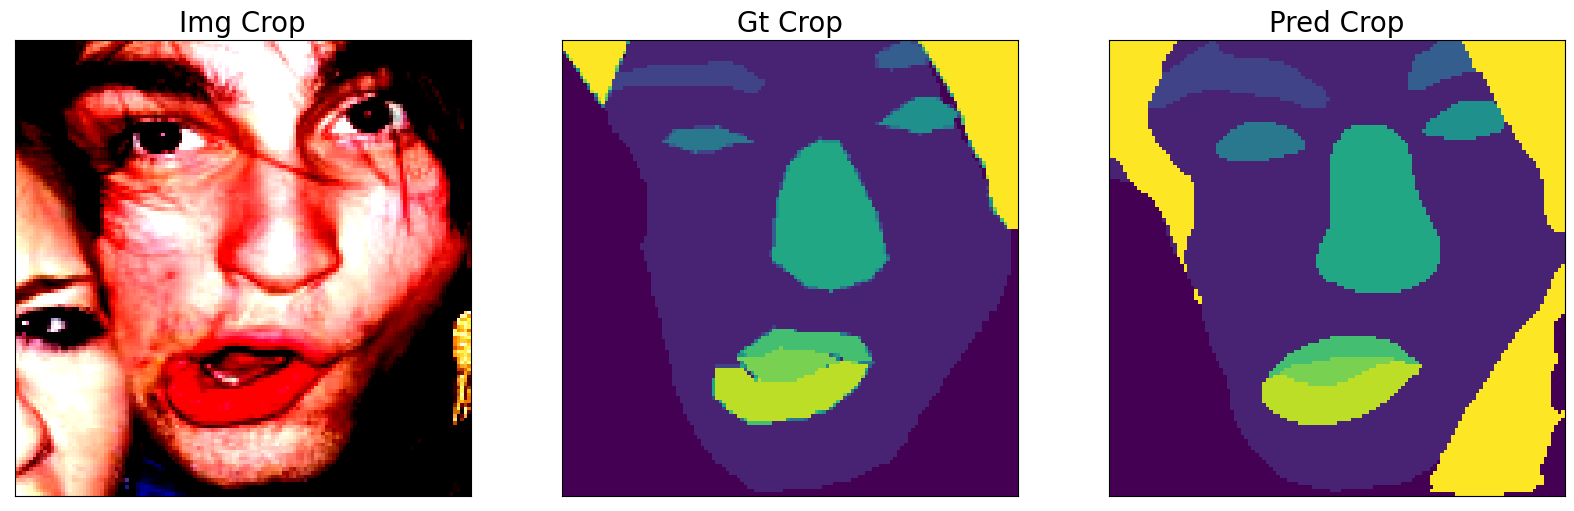

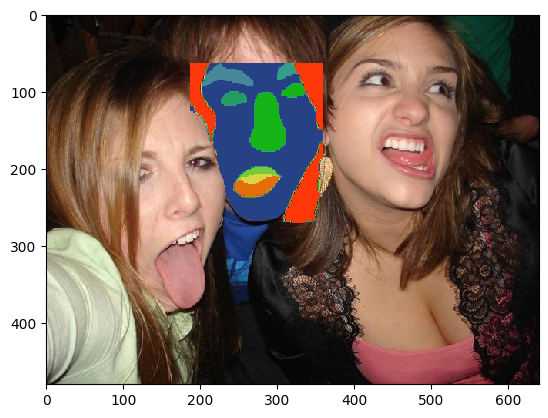

Dataset F1 =  [0.6115788  0.89991343 0.41681513 0.46860248 0.46157053 0.4798832
 0.82242525 0.58662736 0.5131198  0.6639     0.57141346 0.09999996]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset F1 =  [0.7529425  0.9224362  0.64562726 0.6504156  0.6778359  0.6704006
 0.8898464  0.5736379  0.6640972  0.812537   0.650722          nan]
Dataset F1 av =  nan
MOBILE:


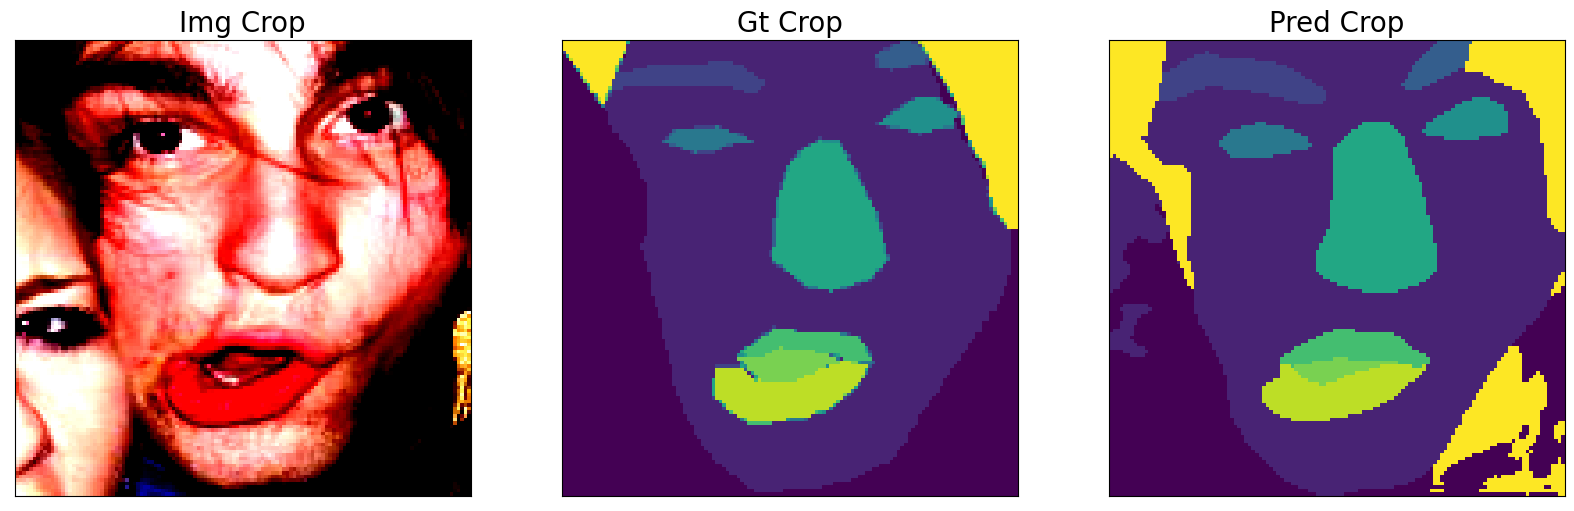

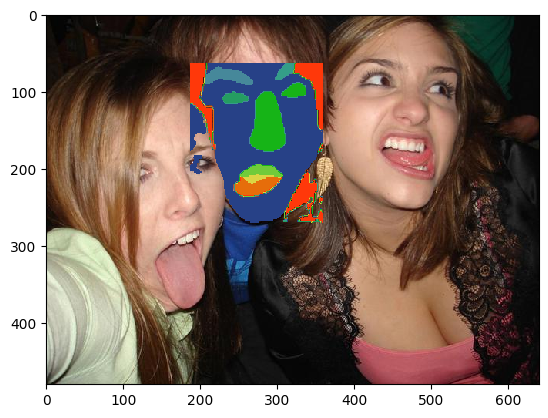

Dataset F1 =  [0.6162468  0.90512323 0.44234067 0.49011606 0.46108478 0.47155648
 0.82977194 0.59037715 0.50229186 0.6634774  0.58783233 0.09999996]
Dataset F1 =  [0.75313944 0.92246747 0.6452709  0.6509309  0.6781072  0.6698842
 0.889729   0.5741064  0.6640838  0.81173086 0.6501798         nan]
Dataset F1 av =  nan


In [24]:

print("deeplab:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/mixed/deeplab.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes, amount=-1, visualise=True)
label_test_script.view_label_predictions(model,val_ds, num_classes,adapt_path="/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", visualise=False)

print("FPN:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/mixed/fcn.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes, amount=-1, visualise=True)
label_test_script.view_label_predictions(model,val_ds, num_classes, adapt_path="/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", visualise=False)


print("UNET:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/mixed/unet.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes, amount=-1, visualise=True)
label_test_script.view_label_predictions(model,val_ds, num_classes, adapt_path="/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", visualise=False)

print("MOBILE:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/mixed/mobile.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes, amount=-1, visualise=True)
label_test_script.view_label_predictions(model,val_ds, num_classes,adapt_path="/home/nathan/Documents/final_project/saved_models/label_adapted_wood.pth", visualise=False)